In [3]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer # Import SimpleImputer
import matplotlib.pyplot as plt # Import for plotting
import seaborn as sns

In [4]:
file_path = "../data/Lung_Cancer_Dataset_Corrupted.csv"
df = pd.read_csv(file_path)

In [5]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        imputer = SimpleImputer(strategy='median')
        df[col] = imputer.fit_transform(df[[col]]).flatten()

C:\Users\admin\AppData\Local\Temp\ipykernel_30912\1779797709.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [6]:
df['GENDER'] = df['GENDER'].round().astype(int)
df['AGE'] = df['AGE'].round().astype(int)
df['ENERGY_LEVEL'] = df['ENERGY_LEVEL'].round().astype(int)
df['OXYGEN_SATURATION'] = df['OXYGEN_SATURATION'].round().astype(int)

In [ ]:
def winsorize(series, limits=(0.05, 0.05)):
    lower, upper = series.quantile(limits[0]), series.quantile(1 - limits[1])
    return series.clip(lower=lower, upper=upper)

df['ENERGY_LEVEL'] = winsorize(df['ENERGY_LEVEL'])
df['OXYGEN_SATURATION'] = winsorize(df['OXYGEN_SATURATION'])
df[df.columns[-1]] = df[df.columns[-1]].map({'YES': 1, 'NO': 0})

NameError: name 'df' is not defined

In [10]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
selector = SelectKBest(score_func=mutual_info_classif, k='all') # Or choose a specific k
X_selected = selector.fit_transform(X, y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
scaler = RobustScaler()  # Or StandardScaler if you prefer
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
param_grid = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy') # or other scoring metrics
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [14]:
best_k = grid_search.best_params_['n_neighbors']
best_weight = grid_search.best_params_['weights']
knn_model = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight)
knn_model.fit(X_train_scaled, y_train)
knn_accuracy = knn_model.score(X_test_scaled, y_test)

print(f"Best K: {best_k}, Best Weight: {best_weight}")
print(f"KNN Accuracy: {knn_accuracy:.4f}")

Best K: 18, Best Weight: distance
KNN Accuracy: 0.8270


In [15]:
joblib.dump(knn_model, "knn_model.pkl")

['knn_model.pkl']

In [16]:
print("\nClass Distribution:")
print(df[df.columns[-1]].value_counts())


Class Distribution:
PULMONARY_DISEASE
0    3175
1    1825
Name: count, dtype: int64


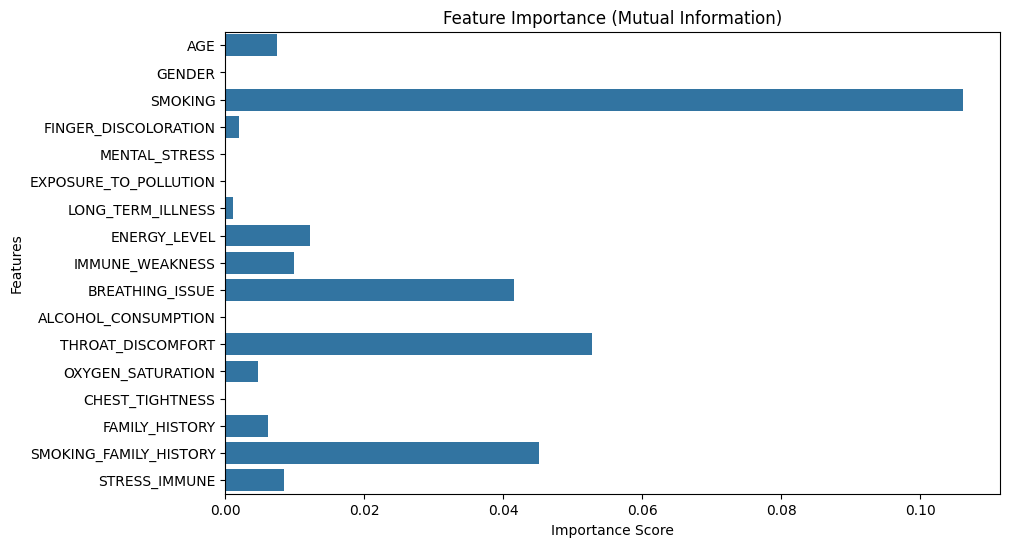

In [17]:
feature_importances = selector.scores_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=X.columns)
plt.title("Feature Importance (Mutual Information)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()